In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

In [3]:
columns = ['datetime', 'typenum', 'subtypenum', 'userip', 'userid', 'expid', 'agent',  'referer']
df = pd.read_csv('data/data', sep='*', header=None, names=columns)
df.sample(5)

,datetime,typenum,subtypenum,userip,userid,expid,agent,referer
13747,2024-09-20 10:14:32,0,1,193.106.2.214,1338173442254,3287528539188,'Mozilla/5.0 (Linux; Android 10; K) AppleWebKi...,'https://odysseus.ctc.ru/'
32058,2024-09-20 16:46:10,0,1,178.178.209.250,0,3289371359857,'Mozilla/5.0 (iPhone; CPU iPhone OS 17_6 like ...,'https://odysseus.ctc.ru/'
10129,2024-09-20 08:39:19,0,1,46.61.174.102,0,3287133532664,'Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...,'https://player.mediavitrina.ru/'
26544,2024-09-20 15:47:42,0,1,79.136.212.74,160927878704,3289077979521,'Mozilla/5.0 (Linux; Android 10; K) AppleWebKi...,'https://odysseus.ctc.ru/'
44140,2024-09-20 20:15:19,0,1,176.59.97.237,1197305571609,3290459791872,'Mozilla/5.0 (Linux; arm; Android 10; M2006C3M...,'https://odysseus.ctc.ru/player/357/956101'


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59840 entries, 0 to 59839
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    59840 non-null  object
 1   typenum     59840 non-null  int64 
 2   subtypenum  59840 non-null  int64 
 3   userip      59840 non-null  object
 4   userid      59840 non-null  int64 
 5   expid       59840 non-null  int64 
 6   agent       59840 non-null  object
 7   referer     54966 non-null  object
dtypes: int64(4), object(4)
memory usage: 3.7+ MB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'].is_monotonic_increasing

False

In [6]:
df.sort_values('datetime', inplace=True)
df.index=df['datetime']
print(df['datetime'].min(), df['datetime'].max(), sep='\n')
df.drop(columns='datetime', inplace=True)

2024-09-20 00:03:22
2024-09-20 23:55:40


In [7]:
df.referer.nunique()

292

In [8]:
df.referer.isna().sum()

4874

In [9]:
df.referer.replace(np.nan, 'https://none./', inplace=True)

In [10]:
def sep_referer(x):
    x = x.split('.')[0]
    x = x.replace("https://", '')
    x = x.replace("http://", '')
    x = x.replace("'", "")
    return x
    
    
df['referer'] = df['referer'].progress_apply(sep_referer)

100%|████████████████████████████████████████████████████████████████████████| 59840/59840 [00:00<00:00, 528184.95it/s]


In [11]:
referers = df.referer.value_counts()
display(referers)

odysseus         39816
player            8936
none              4874
static-limehd     3339
wink               846
rutube             752
imasdk             736
hd                 397
limehd              69
russia-tv           49
v                   11
litehd               8
kino                 5
beeline              1
www                  1
Name: referer, dtype: int64

In [12]:
df.typenum.value_counts()

0    59162
1      678
Name: typenum, dtype: int64

In [13]:
df.subtypenum.value_counts()

1    59840
Name: subtypenum, dtype: int64

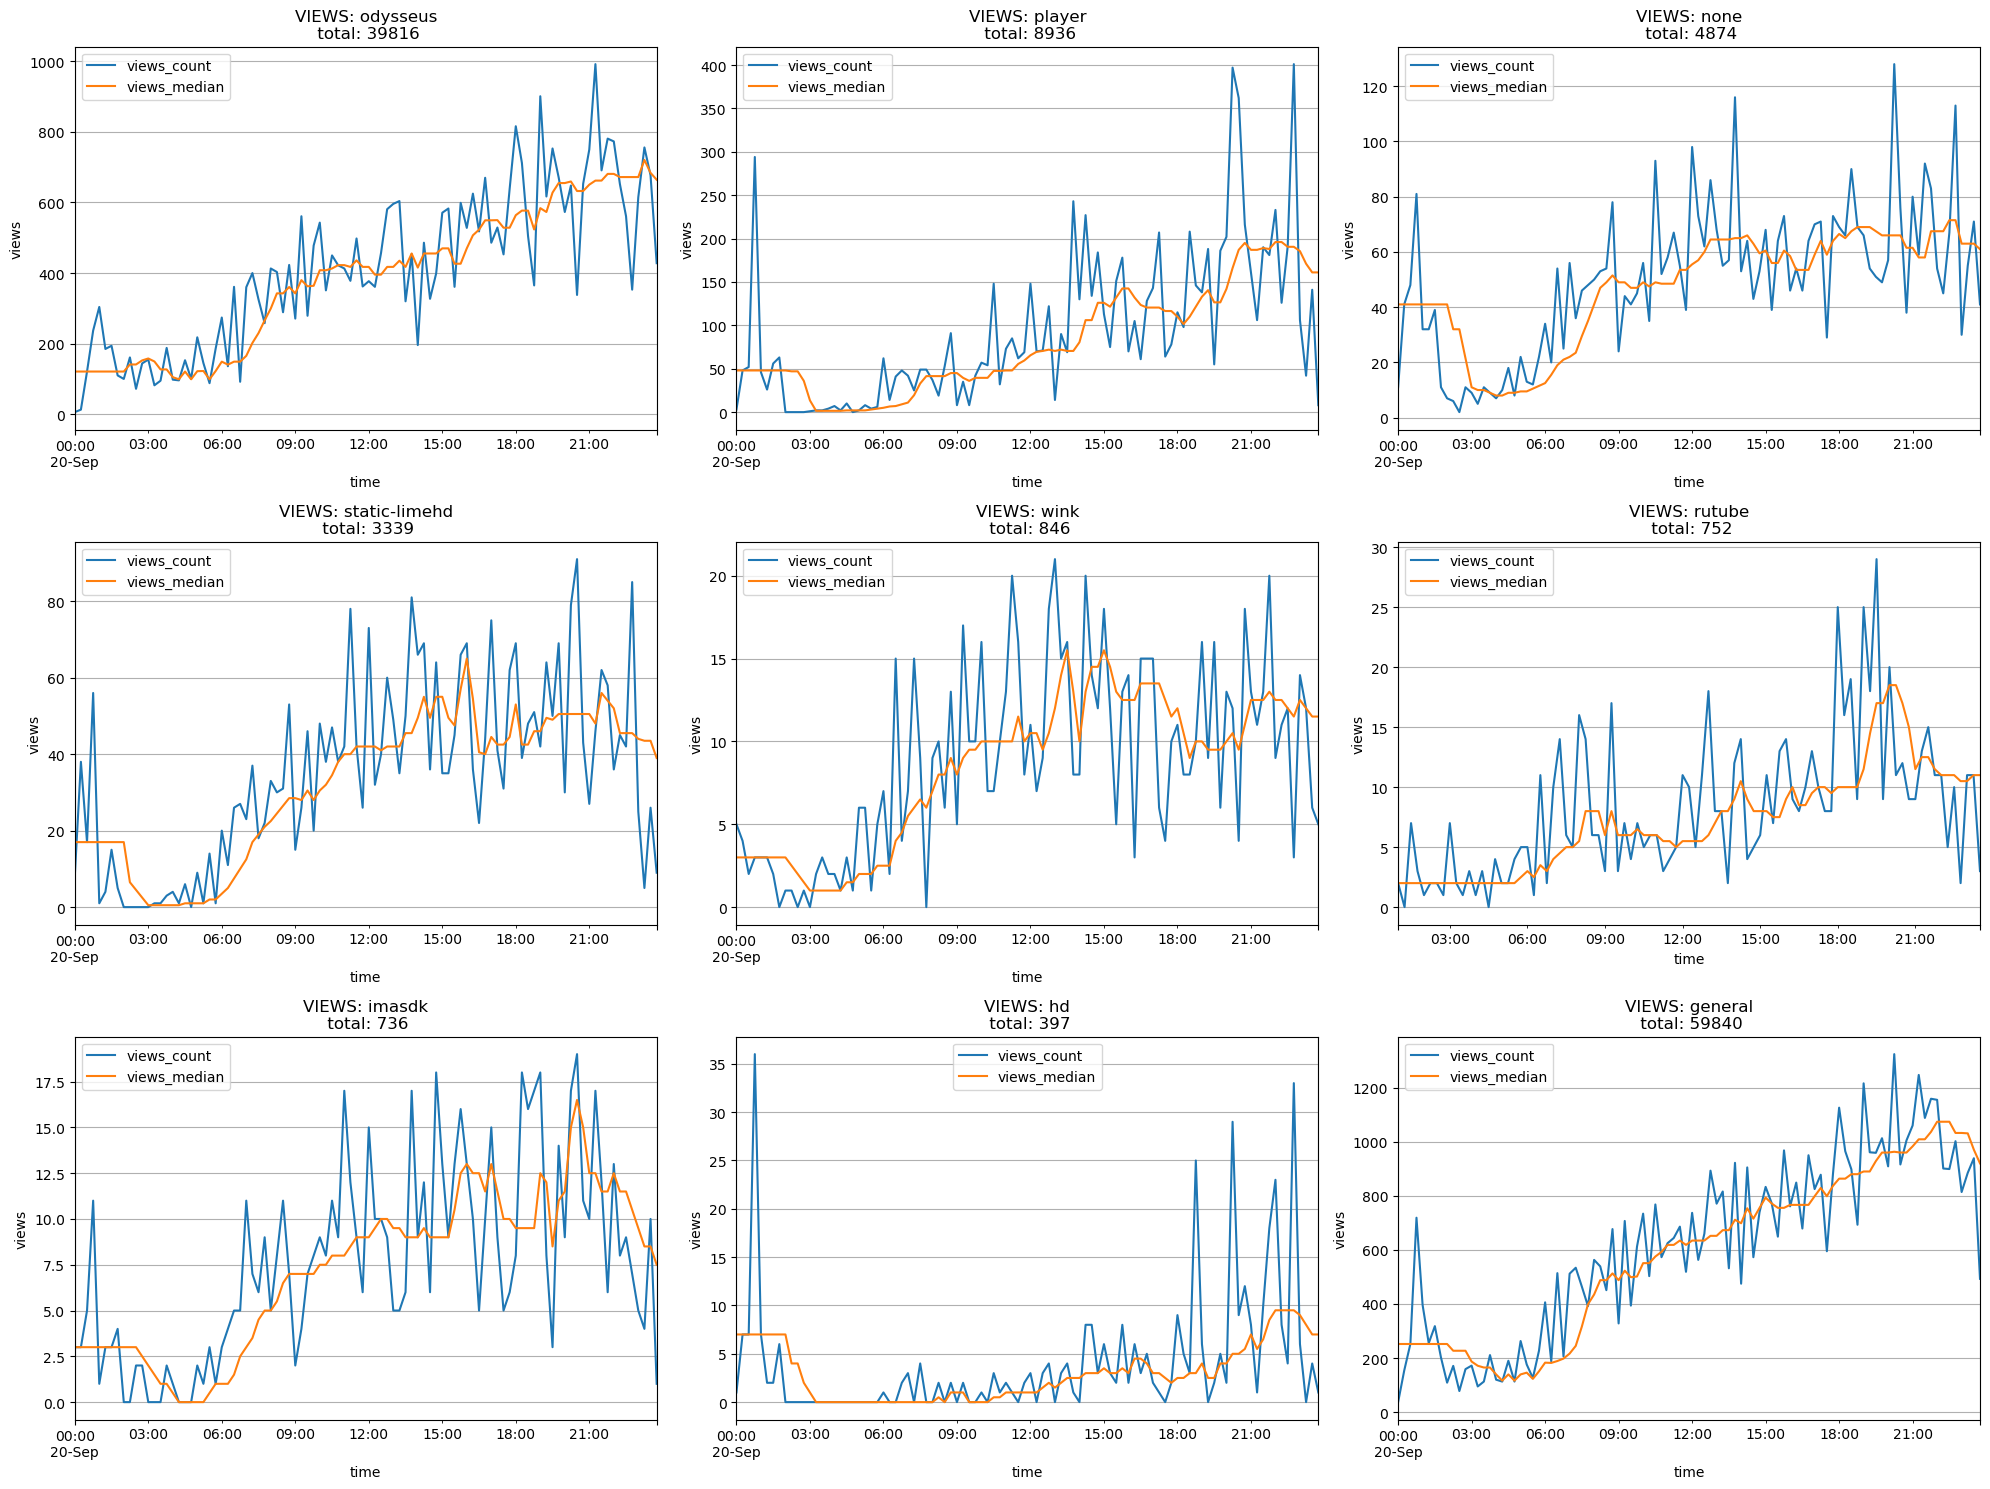

In [39]:
columns_to_drop = ['typenum', 'userid', 'expid', 'agent',  'referer', 'userip']
typenum = 0
window1 = '15min'
window2 = 10
rename = 'views_count'

fig, axes = plt.subplots(figsize=(20, 15), ncols=3, nrows=3)
axes = axes.ravel()
for i, ref in enumerate(referers.index[:8]):
    ax = axes[i]
    df_views = df.query('typenum == @typenum and referer == @ref').drop(columns=columns_to_drop)
    df_views_res = df_views.resample(window1).sum()
    df_views_res.rename(columns={'subtypenum': rename}, inplace=True)

    df_views_res['views_median'] = df_views_res.rolling(window2).median()
    df_views_res['views_median'].fillna(df_views_res[rename][:window2//2].median(), inplace=True)
    df_views_res[rename].plot(grid=True, xlabel='time', ylabel='views', ax=ax, legend=True)
    df_views_res['views_median'].plot(grid=True, xlabel='time', ylabel='views', ax=ax, legend=True)
    ax.set_title('VIEWS: ' + ref + '\n' + ' total: ' + str(referers[ref]))

ax = axes[8]
df_views = df.query('typenum == @typenum').drop(columns=columns_to_drop)
df_views_res = df_views.resample(window1).sum()
df_views_res.rename(columns={'subtypenum': rename}, inplace=True)

df_views_res['views_median'] = df_views_res.rolling(window2).median()
df_views_res['views_median'].fillna(df_views_res[rename][:window2//2].median(), inplace=True)
df_views_res[rename].plot(grid=True, xlabel='time', ylabel='views', ax=ax, legend=True)
df_views_res['views_median'].plot(grid=True, xlabel='time', ylabel='views', ax=ax, legend=True)
ax.set_title('VIEWS: general' + '\n' + ' total: ' + str(referers.sum()))

plt.tight_layout()
plt.show()

In [15]:
df_clicks = df.query('typenum==1')
referers_clicks = df_clicks.referer.value_counts()
referers_clicks

odysseus    524
none        116
player       25
rutube        6
wink          4
hd            3
Name: referer, dtype: int64

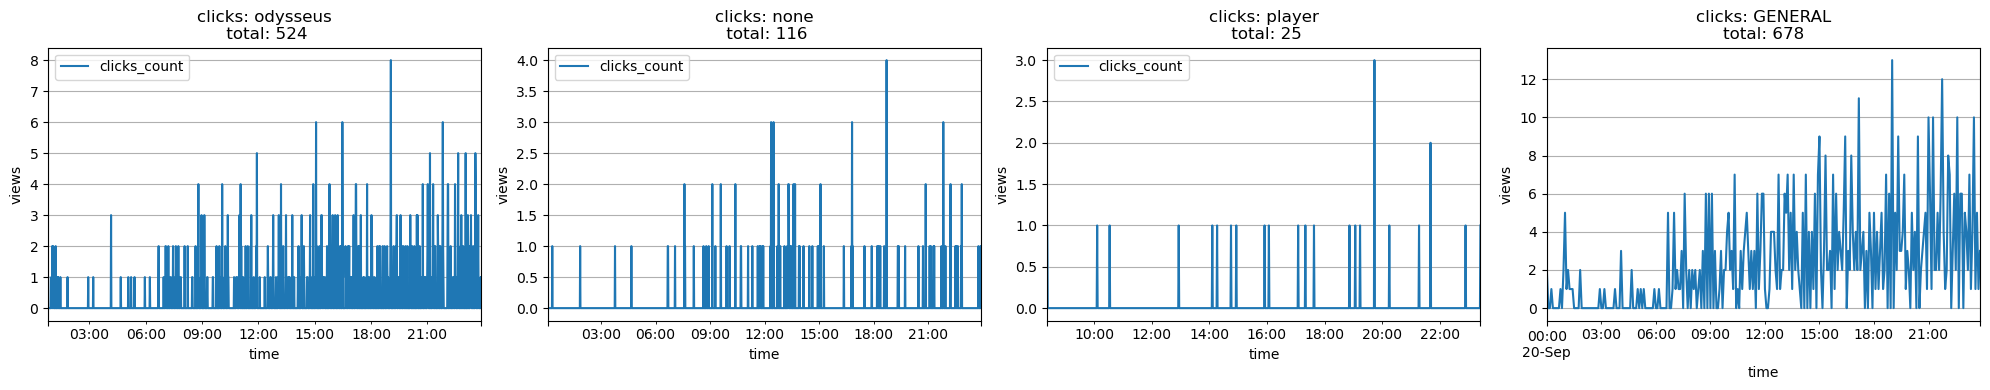

In [84]:
typenum = 1
window1 = '1min'
rename = 'clicks_count'

fig, axes = plt.subplots(figsize=(20, 4), ncols=4, nrows=1)
axes = axes.ravel()
for i, ref in enumerate(referers_clicks.index[:3]):
    ax = axes[i]
    df_clicks = df.query('typenum == @typenum and referer == @ref').drop(columns=columns_to_drop)
    df_clicks_res = df_clicks.resample(window1).sum()
    df_clicks_res.rename(columns={'subtypenum': rename}, inplace=True)
    df_clicks_res[rename].plot(grid=True, xlabel='time', ylabel='views', ax=ax, legend=True)
    ax.set_title('clicks: ' + ref + '\n' + ' total: ' + str(referers_clicks[ref]))

ax = axes[3]
df_clicks = df.query('typenum == @typenum').drop(columns=columns_to_drop)
df_clicks_res = df_clicks.resample('5min').sum()
df_clicks_res['subtypenum'].plot(grid=True, xlabel='time', ylabel='views', ax=ax).set_title('clicks: GENERAL'+ '\n' + 'total: ' + str(referers_clicks.sum()))  

plt.tight_layout()
plt.show()

## Вывод:

### краткий анализ:
- данные представлены за 20.09.2024 период с 00:03:22 до 2024-09-20 23:55:40;
- за этот период всего было 59 840 просмотров и 678 кликов (суммарно по всем реферерам);
- лидеры по просмотрам:
    * odysseus         39816
    * player            8936
    * none              4874
    * static-limehd     3339
    * wink               846
    
- лидеры по кликам:
    * odysseus    524
    * none        116
    * player       25
    * rutube        6
    * wink          4
    * hd            3
 

### есть ли тут трафик от ботов, накрутка, или нет?
- с высокой долей вероятности был трафик от ботов в просмотрах (примерно в 1:00 ночи). Схожая подозрительная активность прослеживается у большинства рефереров;
- в кликах аномалий не обнаружено;

Более точные выводы трудно сделать из-за небольшого количества данных и отсутствия понимания их специфики.